<a href="https://colab.research.google.com/github/ronykroy/DNN-NLP-and-other-stuff/blob/master/UlmFit_newsGroups.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# based on https://github.com/fastai/course-v3/blob/master/nbs/dl1/lesson3-imdb.ipynb
# but using newsgroups data...

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [0]:
import fastai
from fastai import *
from fastai.text import * 
import pandas as pd
import numpy as np
from functools import partial
import io
import os

In [0]:
from sklearn.datasets import fetch_20newsgroups
dataset = fetch_20newsgroups(shuffle=True, random_state=1, remove=('headers', 'footers', 'quotes'))
documents = dataset.data

In [0]:
#type(documents)

In [0]:
df = pd.DataFrame({'label':dataset.target, 'text':dataset.data})

In [0]:
df.shape

(11314, 2)

In [0]:
df.dropna(inplace=True)

In [0]:
df.shape

(11314, 2)

In [0]:
path_d  = pathlib.PosixPath('/sample_data2')

In [0]:
if not os.path.exists(path_d):
    os.mkdir(path_d) 

In [0]:
df.rename({'label':'target','text':text},inplace=True) # renaming cols

In [0]:
bs=32 # was 48
# goal fit as much as possible in memory 32 had no issue
# 128 ran out of memory
# 64 runs out of memory at final stage of classifier trianing unfreeze

In [0]:
from sklearn.model_selection import train_test_split
df_trn, df_test = train_test_split(df, stratify = df['label'], test_size = 0.15, random_state = 11) # test_size is debatable
df_trn, df_val = train_test_split(df_trn, stratify = df_trn['label'], test_size = 0.15, random_state = 11) 

## The language model

In [0]:
data_lm = TextLMDataBunch.from_df(train_df = df_trn, valid_df = df_val, path = path_d)
# whatever means/ method you use to make the lm model's data bunch...
# use the same for making the classifier data bunch

In [0]:
data_lm.save( path_d/'data_lm.pkl') # saving as a back stop

/usr/local/lib/python3.6/dist-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type CrossEntropyLoss. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [0]:
data_lm = load_data( '/sample_data2','data_lm.pkl', bs=bs) # give the path and the file in to which this was saved earlier.. 

In [0]:
data_lm.show_batch()

idx,text
0,"squeezed xxmaj titles , here 's a crude \n picture : \n \n xxrep 22 = xxmaj figure 1 xxrep 36 = \n | \n | + xxrep 9 - + + xxrep 9 - + + xxrep 9 = + \n | + title a + + title b + + title c + \n | + xxrep 24 - + + xxrep"
1,"you ca n't move xxmaj ripken out of the # 3 \n spot , why not move the rest of the line up ? ) \n xxup would xxup be a xxup good xxup sign : xxmaj glenn xxmaj davis wins comeback player of the year . \n xxup would xxup be a xxup bad xxup sign : xxmaj in a tight pennant race , team trades"
2,"their guilt . \n \n xxmaj that the secretary of state may issue an "" xxunk order "" which \n bars someone from ever entering a particular part of the xxmaj united xxmaj kingdom , \n such as xxmaj northern xxmaj ireland or xxmaj wales . \n \n xxmaj that the xxup bbc banned xxmaj paul mccartney 's "" xxmaj give xxmaj ireland xxmaj back to"
3,"same time , simultaneously . \n \n xxmaj any help well appreciated . xxbos \n \n > \t xxmaj the defenition of the xxmaj underdog is a team that has no talent and comes \n > out of nowhere to contend . xxmaj the ' 69 xxmaj mets and ' 89 xxmaj orioles are prime examples , \n > not the xxmaj cubs . \n \n"
4,"\n that file , you have a good chance of getting part of the directory and xxup fat \n from the other disk written to the new disk . xxmaj this has always been true , \n and has destroyed data under other programs , not just cview . \n \n xxmaj the only thing cview can do to improve the situation is to try not"


In [0]:
learn = language_model_learner(data_lm, AWD_LSTM, drop_mult=0.3)

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


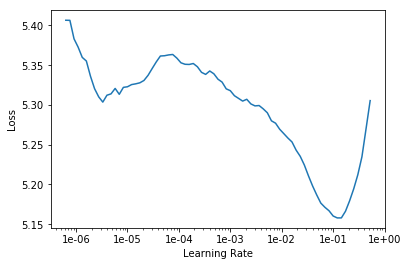

In [0]:
learn.recorder.plot(skip_end=15)

In [0]:
learn.fit_one_cycle(10, 1e-2, moms=(0.8,0.7)) # 1e-2 works fair enough as usual 

epoch,train_loss,valid_loss,accuracy,time
0,4.314060,4.089117,0.275545,07:39
1,3.823380,4.053627,0.275160,07:40
2,4.016834,4.094737,0.272546,07:40
3,3.900708,4.091317,0.276083,07:40
4,3.806482,4.061261,0.280934,07:40
5,3.560475,4.051061,0.282974,07:40
6,3.490449,4.017698,0.287846,07:40
7,3.256065,4.001022,0.290655,07:40
8,3.007553,3.998887,0.292218,07:41
9,3.085167,3.997532,0.292788,07:40


For a language model the accuracy being low is fine..

In [0]:
learn.save('fit_head') 

In [0]:
learn.load('fit_head');

In [0]:
learn.unfreeze() # unfreeze all layers to compete the training of full model

In [0]:
learn.fit_one_cycle(10, 1e-3, moms=(0.8,0.7)) # do a full 10 epochs this time around
# unlike the classifier's case.. we are not using a slice here..
# because we dont experience the losses going [exploding] up phenomenon here....?

epoch,train_loss,valid_loss,accuracy,time
0,3.019767,3.944939,0.304398,08:46
1,2.998919,3.892788,0.313871,08:46
2,2.811089,3.892653,0.315618,08:46
3,2.751428,3.882148,0.324984,08:46
4,2.569558,3.915074,0.328590,08:46
5,2.389743,3.949040,0.329886,08:46
6,2.091447,3.995689,0.331241,08:46
7,2.057675,4.044073,0.331113,08:46
8,1.858850,4.089037,0.331706,08:46
9,1.893411,4.108246,0.330950,08:47


In [0]:
learn.save('fine_tuned') # save # stop gap

In [0]:
learn.load('fine_tuned');

In [0]:
TEXT = "and today"
N_WORDS = 40
N_SENTENCES = 2 # test how good the model is at predicting the next few words

In [0]:
print("\n".join(learn.predict(TEXT, N_WORDS, temperature=0.75) for _ in range(N_SENTENCES)))

and today i bought a ' 90 MB Hd for sale . It came with a 
  brand new Apple wb - only card . It comes with a HD 's 
  Quantum LPS
and today 's SATURDAY Night Live SHOWS - i said that when 
  the day is first i will see the demonstration . 
  If you want to wait , i 'll have the day . xxbos


In [0]:
learn.save_encoder('fine_tuned_enc') # we need the encoder in particular.. not exactly the model that predicts next word

## The Actual Classifier

In [0]:
# Classifier model data
#data_clas = TextClasDataBunch.from_df(path = path_d, train_df = df_trn, valid_df = df_val, vocab=data_lm.train_ds.vocab, bs=bs)
data_clas = TextClasDataBunch.from_df(path = path_d, train_df = df_trn, valid_df = df_val, test_df=df_test, vocab=data_lm.train_ds.vocab, bs=bs)

In [0]:
learn = text_classifier_learner(data_clas, AWD_LSTM, drop_mult=0.5) # the actual classifier

In [0]:
learn.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (8173 items)
x: TextList
xxbos i consider xxup twm - style xxmaj squeezed xxmaj titles xxunk in a window 
  manager . i like to have two tall xterm windows visible at the same 
  time , with no overlap ; and since two windows are n't enough , i have 
  other xterm windows underneath them , with exactly the same positioning . 
 
  xxmaj in case you 're not familiar with xxmaj squeezed xxmaj titles , here 's a crude 
  picture : 
 
  xxrep 22 = xxmaj figure 1 xxrep 36 = 
  | 
  | + xxrep 9 - + + xxrep 9 - + + xxrep 9 = + 
  | + title a + + title b + + title c + 
  | + xxrep 24 - + + xxrep 30 - + 
  | + this is the + + window b hides window c , but + 
  | + body of the + + you can still see c 's title + 
  | + window , window a + + which is squeezed right . + 
  | + xxrep 24 - + + xxrep 30 - + 
  | 
  xxrep 22 = xxmaj figure 1 xxrep 36 = 
 
  xxmaj squeezed titles allow me to have about 5 such windows in each stack , 
  with easy access

In [0]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


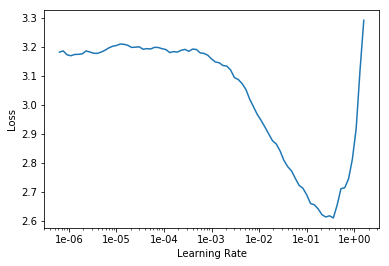

In [0]:
learn.recorder.plot()

In [0]:
learn.fit_one_cycle(3, 1e-2, moms=(0.8,0.7)) 

epoch,train_loss,valid_loss,accuracy,time
0,1.533779,1.331054,0.600832,05:26
1,1.410977,1.155092,0.654193,05:07
2,1.249894,1.156397,0.650035,04:48


In [0]:
learn.save('first')

In [0]:
learn.load('first'); # save and load the state where the last layer alone is what has been retrained..

In [0]:
learn.freeze_to(-2) # unfreeze last 2 layers
#learn.fit_one_cycle(2, 1e-2, moms=(0.8,0.7))# and then train them

In [0]:
learn.fit_one_cycle(2, slice(1e-2/(2.6**4),1e-2), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,1.376572,1.179297,0.632017,05:53
1,1.113293,1.097845,0.656272,05:22


In [0]:
# https://forums.fast.ai/t/continue-training-an-already-trained-model/34790
# learn.fit_one_cycle(2, 1e-2) # Another 2 cycles

In [0]:
learn.save('second')

In [0]:
learn.load('second');

In [0]:
learn.freeze_to(-3)
learn.fit_one_cycle(2, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7)) # almost half an order lower in range this time

epoch,train_loss,valid_loss,accuracy,time
0,1.134160,1.056748,0.668053,06:49
1,0.820568,1.009615,0.699931,06:19


In [0]:
learn.save('third')# todo: some other steps.. and possibly a callback for saving best model

In [0]:
learn.load('third')

In [0]:
learn.unfreeze() # unfreze all
learn.fit_one_cycle(3, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy,time
0,0.774484,0.977860,0.705475,08:41
1,0.749806,0.980315,0.710326,08:53
2,0.662601,0.970425,0.717949,07:31


In [0]:
learn.save('unfreeze_all')

In [0]:
learn.load('unfreeze_all')

In [0]:
# 60-> 70% improvement in accuracy 1 1 2 4 : CYCLES
# 3224 -> 70+% # NO EPOCHs 3223

In [0]:
# next steps 

In [0]:
preds, targets = learn.get_preds() #gets preds of the validation data set

In [0]:
predictions = np.argmax(preds, axis = 1)
pd.crosstab(predictions, targets)

col_0,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
row_0,,,,,,,,,,,,,,,,,,,,
0,34,0,0,0,0,1,0,2,4,1,2,2,1,5,0,8,4,2,2,9
1,0,43,5,6,1,5,0,1,0,2,0,1,6,1,2,1,0,0,0,0
2,0,8,51,9,1,0,4,0,0,0,0,2,0,0,0,1,1,0,0,1
3,0,3,11,45,5,0,3,0,0,0,0,0,5,0,0,0,0,0,0,0
4,0,4,2,8,55,1,1,1,1,1,0,0,5,0,2,0,2,0,1,0
5,2,4,3,1,1,64,2,0,2,0,0,2,0,0,1,1,1,1,0,0
6,0,0,1,2,1,1,54,3,2,0,0,0,0,0,0,0,0,0,0,0
7,2,0,1,0,1,0,1,59,12,1,1,0,5,1,1,0,2,1,2,1
8,4,0,0,0,1,0,3,7,48,1,4,0,0,0,1,0,0,0,1,0


In [0]:
np.sum((targets ==predictions.squeeze()).numpy())/df_val.shape[0] # accuracy checkls out

0.717948717948718

In [0]:
_,preds_t1=preds.topk(1)

In [0]:
preds_t1.squeeze()

tensor([ 2,  5, 15,  ...,  4,  4,  4])

In [0]:
np.sum((targets == preds_t1.squeeze()).numpy())/df_val.shape[0] # topk checks out

0.717948717948718

In [0]:
_,preds_t2 = preds.topk(2)

In [0]:
preds_t2[]

tensor([[ 2,  5],
        [ 5,  2],
        [15, 19],
        ...,
        [ 4, 11],
        [ 4, 11],
        [ 4, 11]])

In [0]:
preds_t2[:,1]

tensor([ 5,  2, 19,  ..., 11, 11, 11])

In [0]:
np.sum((targets == preds_t2[:,1]).numpy())/df_val.shape[0] # no squeeze here

0.11365211365211365

In [0]:
_,preds_t3 = preds.topk(3)

In [0]:
np.sum((targets == preds_t3[:,2]).numpy())/df_val.shape[0] # no squeeze here

0.042966042966042964

In [0]:
#top 3 accuracy
# a contrived way admittedly
a = np.sum((targets == preds_t1.squeeze()).numpy())/df_val.shape[0] 
b = np.sum((targets == preds_t2[:,1]).numpy())/df_val.shape[0] 
c = np.sum((targets == preds_t3[:,2]).numpy())/df_val.shape[0] 


In [0]:
a+b+c

0.8745668745668747

In [0]:
#TODO add the df_test into the data

In [0]:
# getting top k values 
#https://github.com/pytorch/pytorch/issues/22812

## Running classifier on df_test

In [0]:
#preds, targets = learn.get_preds(learn.data.test_ds)
preds, targets = learn.get_preds(DatasetType.Test)

In [0]:
preds

tensor([[9.0699e-06, 8.4475e-04, 9.9555e-01,  ..., 1.7419e-06, 1.5014e-06,
         3.8732e-07],
        [3.0804e-05, 9.0752e-01, 7.9175e-03,  ..., 8.9121e-06, 1.6581e-05,
         3.3157e-05],
        [5.1888e-05, 9.7126e-01, 1.2015e-02,  ..., 1.6015e-05, 2.8513e-06,
         8.0924e-05],
        ...,
        [5.7998e-02, 4.8351e-02, 4.2174e-02,  ..., 3.4702e-02, 3.1545e-02,
         6.4266e-02],
        [5.7998e-02, 4.8351e-02, 4.2174e-02,  ..., 3.4702e-02, 3.1545e-02,
         6.4266e-02],
        [5.7998e-02, 4.8351e-02, 4.2174e-02,  ..., 3.4702e-02, 3.1545e-02,
         6.4266e-02]])

In [0]:
targets # predictably the targets is all zeros\
# see link
# https://forums.fast.ai/t/how-to-reliably-use-get-preds-on-the-test-set-for-ulmfit/34786/4

tensor([0, 0, 0,  ..., 0, 0, 0])